# 1. Build an object detection model using pytorch

Library import

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import os
import torch.nn as nn
import torch.optim as optim
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision import transforms as T
from glob import glob
from PIL import Image
import numpy as np
import torch.nn.functional as F
import random
from PIL import Image
import torchvision.transforms.functional as TF
import pandas as pd
import os
from sklearn.metrics import jaccard_score

Load pre-trained ResNet50 model

Replace the classifier with a new one that has the correct number of output feautures

In [2]:
num_classes=61

Set device to run the model on

In [3]:
class ResNet50ForObecjectDetection(nn.Module):
    def __init__(self, num_classes=61, num_coordinates=4):
        super(ResNet50ForObecjectDetection, self).__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)

        #delete the last layer - to use ResNet50 as a feature extractor
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-1])
        self.classes= nn.Sequential(
            nn.Linear(2048, num_classes),
       
        )
        self.coordinates = nn.Sequential(
            nn.Linear(2048, num_coordinates)
        )

    def forward(self, x):
        x = self.resnet50(x)
        x = x.view(x.size(0), -1)
        coordinates = self.coordinates(x)
        labels=self.classes(x)
        return labels, coordinates

# 2. Train your model using [cow stall number datasets](https://github.com/YoushanZhang/Cow_stall_number)

In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model = ResNet50ForObecjectDetection(num_classes=61, num_coordinates=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load data and normalize data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df_train=pd.read_csv('https://raw.githubusercontent.com/YoushanZhang/Cow_stall_number/main/Train.csv')

In [8]:
df_train=df_train.fillna(0)
df_train

,imageFilename,box_position_1,box_position_2,box_position_3,box_position_4,class_names
0,GH030066_4679.png,287.0,116.0,25.0,23.0,29
1,GH020058_19383.png,275.0,58.0,23.0,24.0,44
2,GH030061_1269.png,306.0,74.0,26.0,25.0,13
3,GH020058_17235.png,0.0,0.0,0.0,0.0,0
4,GH020058_18319.png,288.0,55.0,23.0,23.0,42
...,...,...,...,...,...,...
1037,GH010068_2548.png,277.0,117.0,22.0,22.0,24
1038,GH020061_19829.png,176.0,86.0,23.0,23.0,50
1039,GH050066_29877.png,277.0,119.0,25.0,22.0,53
1040,GH040066_1951.png,281.0,117.0,20.0,19.0,21


In [9]:
df_test=pd.read_csv('https://raw.githubusercontent.com/YoushanZhang/Cow_stall_number/main/Test.csv')
df_test=df_test.fillna(0)
df_test

,imageFilename,box_position_1,box_position_2,box_position_3,box_position_4,class_names
0,GH030061_12040.png,172.0,81.0,25.0,24.0,28
1,GH030072_2783.png,289.0,94.0,23.0,21.0,42
2,GH010059_45.png,0.0,0.0,0.0,0.0,0
3,GH030072_4929.png,288.0,94.0,23.0,23.0,46
4,GH020072_31411.png,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...
256,GH010066_8162.png,272.0,115.0,21.0,23.0,39
257,GH010062_3030.png,187.0,84.0,23.0,24.0,50
258,GH010070_2701.png,277.0,103.0,24.0,23.0,60
259,GH010058_25646.png,261.0,54.0,25.0,22.0,57


Define Class Image Dataset (parent class)

In [10]:
class ImageDataSet(Dataset):
    def __init__(self, img_dir, df):
        self.img_dir = img_dir
        self.file_name = df['imageFilename'].tolist()
        self.x = df['box_position_1'].tolist()
        self.y = df['box_position_2'].tolist()
        self.height = df['box_position_3'].tolist()
        self.width = df['box_position_4'].tolist()
        self.label = df['class_names'].tolist()
        
    def transform(self, image, mask):
        pass
 
    
    def mask_to_box(self,mask):
        if len(np.where(mask==255)[0]) > 0:
            x_scale, y_scale = np.where(mask==255)[1:]

            bbox = torch.tensor([x_scale.min(), y_scale.min(),x_scale.max()-x_scale.min(),y_scale.max()-y_scale.min()])
        else:
            bbox = torch.tensor([0,0,0,0])
        return bbox


        
    def __len__(self):
        return len(self.file_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_name[idx])
        img = Image.open(img_path) 
        label = torch.tensor(self.label[idx], dtype = torch.long)
        mask = np.zeros((img.size[1], img.size[0]))
        bbox = [self.x[idx],self.y[idx],self.height[idx],self.width[idx]]

        bbox = np.array(bbox, dtype = 'int')
        mask[bbox[1]:bbox[1]+bbox[3]+1,bbox[0]:bbox[0]+bbox[2]+1]=255
        mask = Image.fromarray(mask)
       
       
        img, mask = self.transform(img, mask)

            
        bbox = self.mask_to_box(mask)

        return img, bbox, label

Define Class Train Image Dataset 

In [11]:
class TrainDataSet(ImageDataSet):
        
    def __init__(self, img_dir, df):
         super(TrainDataSet, self).__init__(img_dir, df)

    def transform(self, image, mask):
        resize = transforms.Resize(size=(270,270))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(224,224))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        
        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Center crop
        image = transforms.CenterCrop((224,224))(image)
        mask = transforms.CenterCrop((224,224))(mask)
            
        # Random rotation   
        if random.random() > 0.5:
            angle = random.randint(-10, 10)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        
        
        color_t = transforms.ColorJitter() 
        
        # Transform to tensor
        image = TF.to_tensor(image)
        image = TF.normalize(image,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        mask = TF.to_tensor(mask)
        return image, mask
 


Define Class Test Image Dataset

In [12]:
class TestDataSet(ImageDataSet):
    def __init__(self, img_dir, df):
         super(TestDataSet, self).__init__(img_dir, df)
 
    def transform(self, image, mask):
        resize = transforms.Resize(size=(270,270))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(224,224))
        
        # Center crop
        image = transforms.CenterCrop((224,224))(image)
        mask = transforms.CenterCrop((224,224))(mask)        
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        mask = TF.to_tensor(mask)
        return image, mask

In [13]:
train_names=df_train['imageFilename'].tolist()

In [14]:
test_names=df_test['imageFilename'].tolist()

In [15]:
directory='/content/drive/MyDrive/Datasets/YU/Stall_num_images'

In [16]:
train_targets=df_train['class_names'].tolist()
test_targets=df_test['class_names'].tolist()

In [17]:
train_files=list(map(lambda x: os.path.join(directory,x),train_names))
test_files=list(map(lambda x: os.path.join(directory,x),test_names))

Split data on train, test and validation data

In [18]:
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8
pin_memory=True

In [19]:
train_dataset = TrainDataSet(directory,df_train)
test_dataset = TestDataSet(directory,df_test)


CREATE LOADERS

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

Freeze all layers

In [21]:
for param in model.parameters():
    param.requires_grad = False
    
total = len(list(model.resnet50.children()))
for i, layer in enumerate(model.resnet50.children()):
    if i >= total - 3: 
        for param in layer.parameters():
            param.requires_grad = True



for param in model.classes.parameters():
    param.requires_grad = True


for param in model.coordinates.parameters():
    param.requires_grad = True

In [22]:
import torch.optim.lr_scheduler as lr_scheduler

In [23]:
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [24]:
optimizer = torch.optim.Adam(list(filter(lambda p: p.requires_grad, model.parameters())), lr=1e-4, weight_decay=5e-4)

In [25]:
def IoU(boxa, boxb):
    box1=[boxa[0],boxa[1],boxa[0]+boxa[3],boxa[1]+boxa[2]]
    box2=[boxb[0],boxb[1],boxb[0]+boxb[3],boxb[1]+boxb[2]]
    x1 = max(box1[0],box2[0])
    y1 = max(box1[1],box2[1])
    x2 = min(box1[2],box2[2])
    y2 = min(box1[3],box2[3])
    
    inter = max(0,x2-x1+1)*max(0, y2-y1+1)
    boxa_area = (boxa[2]+1)*(boxa[3]+1)
    boxb_area = (boxb[2]+1)*(boxb[3]+1)
    iou = inter/float(boxa_area+boxb_area-inter)
    
    return iou

In [26]:
def count_correct_predictions(pred, targets):
    _, pred_classes = torch.max(pred, dim=-1)
    correct = (pred_classes == targets).sum().item()
    return correct


In [27]:
def loss_function(box_target, box_pred, class_target, class_pred):
    iou_losses = []
    box_losses = []
    class_loss = nn.CrossEntropyLoss()(class_pred, class_target)
    
    for i in range(len(box_pred)):
        iou_loss = 1 - IoU(box_pred[i], box_target[i])
        iou_losses.append(iou_loss)
        
        box_loss = F.smooth_l1_loss(box_pred[i], box_target[i], reduction='mean')
        box_losses.append(box_loss)
    
    iou_losses = torch.tensor(iou_losses).to(device)
    iou_loss = iou_losses.mean()
    
    box_losses = torch.tensor(box_losses).to(device)
    box_loss = box_losses.mean()

    loss = 1.0 * class_loss + 0.1 * box_loss + 5.0 * iou_loss
    count = count_correct_predictions(class_pred, class_target)
    return loss, count, iou_loss.item()


In [28]:
criterion = nn.CrossEntropyLoss()
mse_loss = nn.MSELoss()

In [29]:
max_val=75
best_epoch=0

Train the model

In [30]:
num_epochs = 210
all_trainloss= []
all_valloss= []
all_train_iou=[]
all_train_acc = []
all_valid_acc=[]
all_train_iou=[]
all_valid_iou=[]
c=[]


In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss, valid_loss = 0, 0
    train_iou, valid_iou = 0, 0
    train_count, valid_count=0, 0
    for image, box_target, class_target in train_loader:

        # Forward pass
        box_target = box_target.to(torch.float32)
        image, class_target, box_target = image.to(device), class_target.to(device), box_target.to(device)
       
        optimizer.zero_grad()
        class_pred, box_pred = model(image)

        loss, count, iou = loss_function(box_target, box_pred, class_target, class_pred)
        
        l2_regularization = torch.tensor(0.).to('cuda' if torch.cuda.is_available() else 'cpu')
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)
        loss += 0.01 * l2_regularization

        
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()        
        train_count+=count
        train_iou+=iou
        

        
    # Validation    
    model.eval()
    for image, box_target, class_target in test_loader:
        box_target = box_target.to(torch.float32)
        image, class_target, box_target = image.to('cuda' if torch.cuda.is_available() else 'cpu'), class_target.to('cuda' if torch.cuda.is_available() else 'cpu'), box_target.to('cuda' if torch.cuda.is_available() else 'cpu')
        class_pred, box_pred = model(image)
        val_loss, val_count, val_iou = loss_function(box_target, box_pred, class_target, class_pred)
        valid_loss+=val_loss.item()   
        valid_iou+=val_iou
        valid_count+=val_count
        
    train_loss/=len(train_loader)
    valid_loss /= len(test_loader)
    train_iou/=len(train_loader)
    valid_iou /= len(test_loader)   
    train_acc = train_count / len(train_loader.dataset)*100
    valid_acc = valid_count / len(test_loader.dataset)*100
        
    all_trainloss.append(train_loss)
    all_train_acc.append(train_acc)    
    all_valloss.append(valid_loss)
    all_valid_acc.append(valid_acc)
    all_train_iou.append(train_iou*100)
    all_valid_iou.append(valid_iou*100)
    
    scheduler.step(valid_acc)
    
    if valid_acc > max_val:
        name = f'stall_number_detector.pth'
        torch.save(model.state_dict(), name)  
        max_val=valid_acc
        best_epoch=epoch+1



    # Print the loss and accuracy
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f},  testLoss: { valid_loss:.4f}, testAcc: {valid_acc:.4f}")

Epoch 202, Loss: 12.2672, Acc: 99.1363,  testLoss: 7.9061, testAcc: 81.9923
Epoch 203, Loss: 12.2964, Acc: 98.5605,  testLoss: 7.9699, testAcc: 78.9272
Epoch 204, Loss: 12.2144, Acc: 98.8484,  testLoss: 7.9331, testAcc: 78.9272
Epoch 205, Loss: 12.1987, Acc: 99.3282,  testLoss: 7.8214, testAcc: 83.1418
Epoch 206, Loss: 12.2333, Acc: 99.3282,  testLoss: 7.9614, testAcc: 83.5249
Epoch 207, Loss: 12.1766, Acc: 99.4242,  testLoss: 7.8899, testAcc: 80.8429
Epoch 208, Loss: 12.3386, Acc: 98.5605,  testLoss: 8.0099, testAcc: 79.6935
Epoch 209, Loss: 12.2503, Acc: 99.0403,  testLoss: 7.8167, testAcc: 83.5249


The loss function on training and validation data

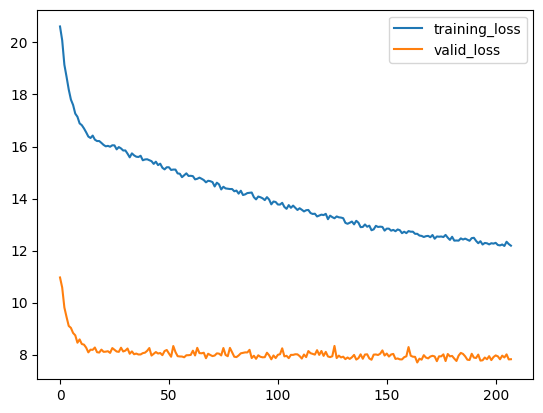

In [ ]:
plt.plot(all_trainloss, label='training_loss')
plt.plot(all_valloss, label='valid_loss')
plt.legend()

The accuracy on training and validation data

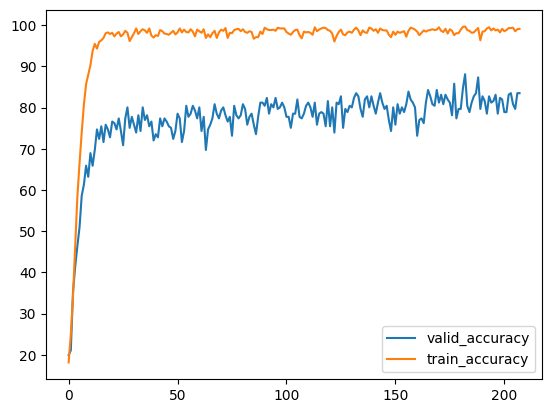

In [ ]:
plt.plot(all_valid_acc, label='valid_accuracy')
plt.plot(all_train_acc, label='train_accuracy')
plt.legend()

# 3.Evaluate your model using the test images

In [33]:
print(f'The best epoch is {best_epoch}')

The best epoch is 183


Model evaluation

In [34]:
clf=ResNet50ForObecjectDetection().to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
with open('stall_number_detector_final.pth', 'rb') as f: 
    clf.load_state_dict(torch.load(f))

In [36]:
test_count=0
test_iou=0

In [37]:
clf.eval()
for image, box_target, class_target in test_loader:
        box_target = box_target.to(torch.float32)
        image, class_target, box_target = image.to(device), class_target.to(device), box_target.to(device)
        class_pred, box_pred = clf(image)
        _, t_count, _ = loss_function(box_target, box_pred, class_target, class_pred)
        
        for i in range(len(box_pred)):
            test_iou+= IoU(box_pred[i], box_target[i])
        test_count+=t_count


In [41]:
test_iou=test_iou/ len(test_loader.dataset)*100

In [35]:
test_acc = test_count / len(test_loader.dataset)*100


In [41]:
print(f'Accuracy on test data is {test_acc:.4f}')

Accuracy on test data is 85.0575


In [42]:
print(f'IoU on test data is {test_iou:.4f}')

IoU on test data is 16.8569


# 4. Your results should be higher than 80%.

# 5. Write a four-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://www.researchgate.net/publication/370139907_CowStallNumbers_Computer_Vision_system_for_Stall_Number_Detection_of_Cow_Teats_Images#fullTextFileContent

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points